In [3]:
import pandas as pd  # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests    # library to handle requests
import urllib.request   # import the library we use to open URLs

In [4]:
#conda install -c conda-forge geocoder
#!conda install -c conda-forge geopy --yes 
import geocoder 
from geopy.geocoders import Nominatim      # convert an address into latitude and longitude values

In [59]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files  
from pandas.io.json import json_normalize      # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


First a GET request for FourSquare API is constructed. Here, we find coffee places/ pubs near Lausanne center, in 1000 m radius. In general it's better to let requests to handle adding parameters to url than manually construct it.

In [6]:
CLIENT_ID = 'NI1SJKPUBAZB0OIGM41FMTG2PPTGS3EGPZFXNJII5123QHOD' # my Foursquare ID
CLIENT_SECRET = '0KCYWQLKDLUXZH1GBIDUY1Y03Q0HSB13WTQ5R54GGIPEXASP' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NI1SJKPUBAZB0OIGM41FMTG2PPTGS3EGPZFXNJII5123QHOD
CLIENT_SECRET:0KCYWQLKDLUXZH1GBIDUY1Y03Q0HSB13WTQ5R54GGIPEXASP


In [7]:
radius = 1000
near = 'Lausanne'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    near,
    radius, 
    LIMIT)

url 

'https://api.foursquare.com/v2/venues/explore?&client_id=NI1SJKPUBAZB0OIGM41FMTG2PPTGS3EGPZFXNJII5123QHOD&client_secret=0KCYWQLKDLUXZH1GBIDUY1Y03Q0HSB13WTQ5R54GGIPEXASP&v=20180605&near=Lausanne,&radius=1000&limit=150'

Let's send teh GET request

In [8]:
results = requests.get(url).json()
#results

All the information that we need is in the items key.

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [10]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-10-2e7946891582>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Sleepy Bear Coffee,Coffee Shop,46.515338,6.631369
1,Les Trois Rois,French Restaurant,46.515515,6.631223
2,Pasta e Sfizi,Italian Restaurant,46.516374,6.633477
3,Café du Simplon,Mediterranean Restaurant,46.515961,6.629948
4,Les Gosses du Québec,Bar,46.517072,6.633122


Let's print how many venues were found by Foursquare.

In [11]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Now let's retrieve the coordinates of Lausanne from the json file, in order to plot the heatmap of the locations.

In [12]:
data = results['response']

In [13]:
lausanne_center = data["geocode"]["center"]
lausanne_center

{'lat': 46.516, 'lng': 6.63282}

Let's plot the map

In [14]:
map_lausanne = folium.Map(location=[lausanne_center["lat"], lausanne_center["lng"]], zoom_start=15)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html=True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_lausanne)

        

map_lausanne

And now let's add the markers for the locations to the map:

In [17]:
#add_markers(nearby_venues)
lm_data = nearby_venues[["lat", "lng"]].values             #as_matrix().tolist()

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lng']] for index, row in nearby_venues.iterrows()]

add_markers(nearby_venues) 

HeatMap(heat_data).add_to(map_lausanne)

map_lausanne

Now that we have added the markers and shown the heatmap, we can analyze the density in different areas of the city and start clustering the locations.

 

Let's see how many venues were retrieved:

In [20]:
print('There are {} venues.'.format(len(nearby_venues['categories'])))

There are 100 venues.


One hot encoding

In [25]:
# one hot encoding
lausanne_onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")

# add venue column back to dataframe
lausanne_onehot['name'] = nearby_venues['name'] 

# move venue name column to the first column
fixed_columns = [lausanne_onehot.columns[-1]] + list(lausanne_onehot.columns[:-1])
lausanne_onehot = lausanne_onehot[fixed_columns]

lausanne_onehot.head()

,name,Art Museum,Bar,Bistro,Bookstore,Breakfast Spot,Burger Joint,Café,Candy Store,Chinese Restaurant,Church,Coffee Shop,Creperie,Cupcake Shop,Department Store,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gastropub,General Entertainment,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Multiplex,Museum,Nightclub,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Plaza,Pool,Restaurant,Rock Club,Sandwich Place,Snack Place,Supermarket,Swiss Restaurant,Tea Room,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Yoga Studio
0,Sleepy Bear Coffee,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Les Trois Rois,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pasta e Sfizi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Café du Simplon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Les Gosses du Québec,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's check the shape of our new dataframe. The rows are the venues obtaine from Foursquare, while the columns are all the unique categories for the venues.

In [56]:
lausanne_onehot.shape

(100, 50)

Before running K-means, we have to decide the number of clusters. A way to do that is with the elbow method, where you test the algorhitm with several different K values and you then choose the most appropriate.

In [57]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(lausanne_onehot_clustering)
    distortions.append(kmeanModel.inertia_)

Let's see the plot for the elbow method.

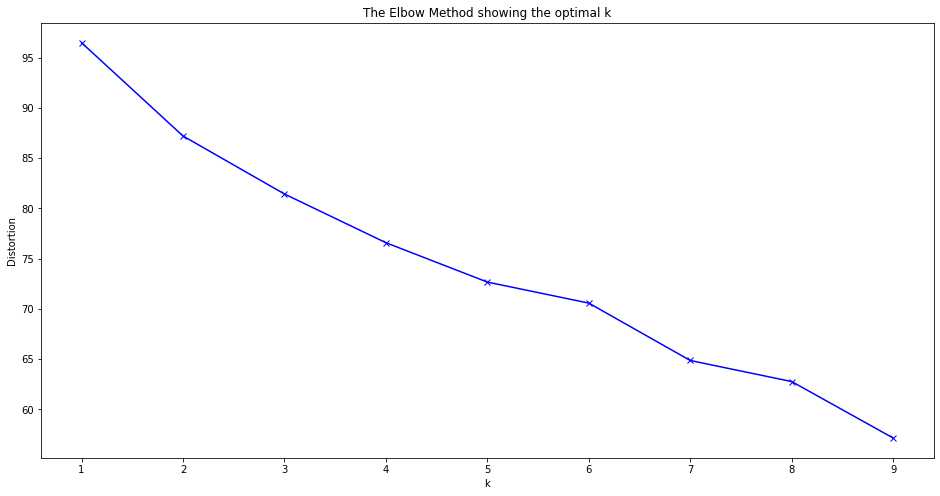

In [60]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We should choose the k which makes the slope change visibly, but in this case is not that clear. Anyway we will choose k = 7.

In [94]:
# set number of clusters
kclusters = 7

lausanne_onehot_clustering = lausanne_onehot.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(lausanne_onehot_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 5, 0, 2, 2, 0, 0, 0, 1])

new dataframe with cluster number

In [95]:
nearby_venues = nearby_venues.drop(['Cluster Labels'], axis=1)

# add clustering labels
nearby_venues.insert(0, 'Cluster Labels', kmeans.labels_)
nearby_venues.head()

,Cluster Labels,name,categories,lat,lng
0,0,Sleepy Bear Coffee,Coffee Shop,46.515338,6.631369
1,1,Les Trois Rois,French Restaurant,46.515515,6.631223
2,5,Pasta e Sfizi,Italian Restaurant,46.516374,6.633477
3,0,Café du Simplon,Mediterranean Restaurant,46.515961,6.629948
4,2,Les Gosses du Québec,Bar,46.517072,6.633122


map

In [96]:
# create map
map_clusters = folium.Map(location=[lausanne_center["lat"], lausanne_center["lng"]], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster-1)],
        fill = True,
        fill_color = rainbow[int(cluster-1)],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

# Results

let's plot the single clusters

In [97]:
Cluster_zero = nearby_venues.loc[nearby_venues['Cluster Labels'] == 0,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_zero.head()

,Cluster Labels,name,categories,lat,lng
0,0,Sleepy Bear Coffee,Coffee Shop,46.515338,6.631369
3,0,Café du Simplon,Mediterranean Restaurant,46.515961,6.629948
6,0,Al Sacco,Sandwich Place,46.515690,6.630438
7,0,Ta Cave,Wine Bar,46.516014,6.628386
8,0,Café de Grancy,Gastropub,46.515265,6.628637


In [98]:
Cluster_one = nearby_venues.loc[nearby_venues['Cluster Labels'] == 1,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_one.head()

,Cluster Labels,name,categories,lat,lng
1,1,Les Trois Rois,French Restaurant,46.515515,6.631223
9,1,Au Chat Noir,French Restaurant,46.517539,6.637225
14,1,"Côté Jardin, Lausanne Palace",French Restaurant,46.519336,6.630655
38,1,Brasserie du Royal,French Restaurant,46.511112,6.628675
43,1,Brasserie Grand-Chêne,French Restaurant,46.519709,6.631117


In [99]:
Cluster_two = nearby_venues.loc[nearby_venues['Cluster Labels'] == 2,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_two.head()

,Cluster Labels,name,categories,lat,lng
4,2,Les Gosses du Québec,Bar,46.517072,6.633122
5,2,Bar Tabac,Bar,46.518066,6.634775
18,2,Café des Artisans,Bar,46.520971,6.634413
28,2,Bourg Plage,Bar,46.521391,6.635939
41,2,La Louve,Bar,46.521081,6.632373


In [100]:
Cluster_three = nearby_venues.loc[nearby_venues['Cluster Labels'] == 3,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_three.head()

,Cluster Labels,name,categories,lat,lng
50,3,Inglewood,Burger Joint,46.522353,6.631424
52,3,The Green Van Company,Burger Joint,46.521442,6.628072
76,3,Holy Cow!,Burger Joint,46.520243,6.636391
79,3,Holy Cow!,Burger Joint,46.522702,6.628219


In [101]:
Cluster_four = nearby_venues.loc[nearby_venues['Cluster Labels'] == 4,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_four.head()

,Cluster Labels,name,categories,lat,lng
82,4,Cafe des Avenues,Café,46.511124,6.636754
89,4,TOM cafe,Café,46.508572,6.634084
96,4,Café de l'Evêché,Café,46.521798,6.635780
97,4,Café Beau-Rivage,Café,46.507793,6.630034
98,4,La Couronne d'Or,Café,46.524748,6.634094


In [102]:
Cluster_five = nearby_venues.loc[nearby_venues['Cluster Labels'] == 5,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_five.head()

,Cluster Labels,name,categories,lat,lng
2,5,Pasta e Sfizi,Italian Restaurant,46.516374,6.633477
27,5,Le Milan,Italian Restaurant,46.516513,6.625852
36,5,Chez Mario,Italian Restaurant,46.520007,6.636311
49,5,Bruschetta,Italian Restaurant,46.517040,6.633437
72,5,Restaurant Piazza San Marco,Italian Restaurant,46.511821,6.629203


In [103]:
Cluster_six = nearby_venues.loc[nearby_venues['Cluster Labels'] == 6,]  # budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

Cluster_six.head()

,Cluster Labels,name,categories,lat,lng
16,6,Eat Me,Restaurant,46.520266,6.632343
24,6,Restaurant de la Croix d'Ouchy,Restaurant,46.511672,6.629726
29,6,Luigia,Restaurant,46.519622,6.637160
81,6,Anne-Sophie Pic,Restaurant,46.507782,6.630619


# Conclusions

We see that kmeans divided the places into clusters of restaurants, bars, cafes, fast food places and miscellaneaous. 

In this case, as an example, the cluster most suitable for a student to live close could be in the cluster 2 or 3. This is because students love to hang out with friends outside and usually have a low budget.